In [33]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, mean_squared_error, r2_score
)
from scipy import stats
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='husl')
plt.style.use('seaborn-v0_8')


In [34]:
# Load the Titanic dataset
titanic = sns.load_dataset('titanic')
print(f"Shape: {titanic.shape}")
print("Columns:", list(titanic.columns))
display(titanic.head())
display(titanic.info())
display(titanic.describe())


Shape: (891, 15)
Columns: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


None

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,Missing Count,Missing %
age,177,19.865320
embarked,2,0.224467
deck,688,77.216611
embark_town,2,0.224467


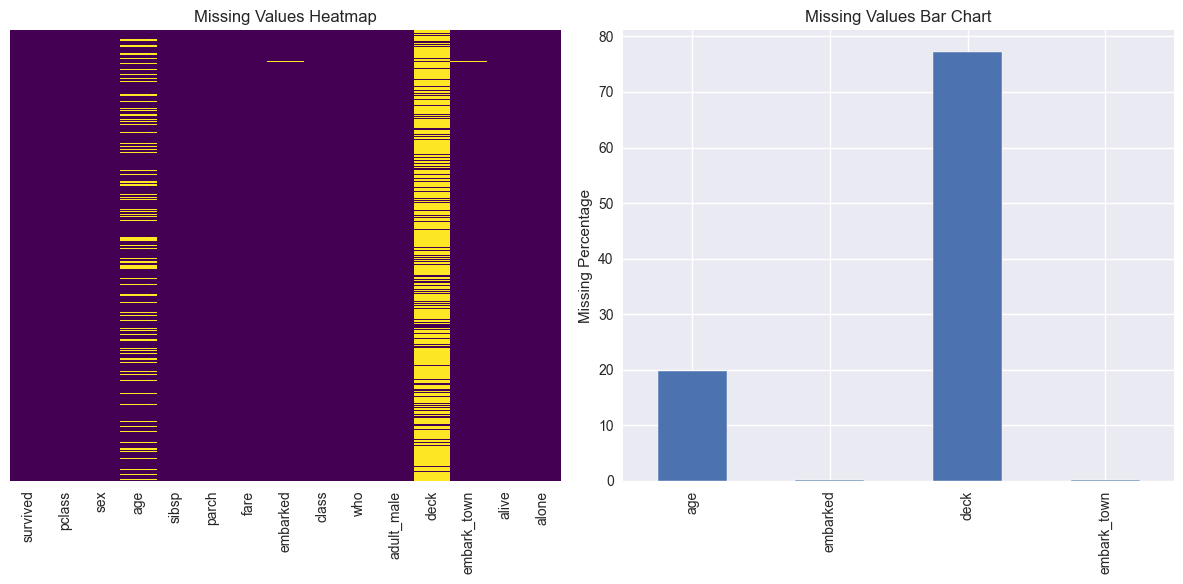

In [35]:
# Missing values
missing = titanic.isnull().sum()
missing_percent = 100 * missing / len(titanic)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
display(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(titanic.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')

plt.subplot(1, 2, 2)
missing_df[missing_df['Missing Count'] > 0]['Missing %'].plot(kind='bar')
plt.ylabel('Missing Percentage')
plt.title('Missing Values Bar Chart')
plt.tight_layout()
plt.show()


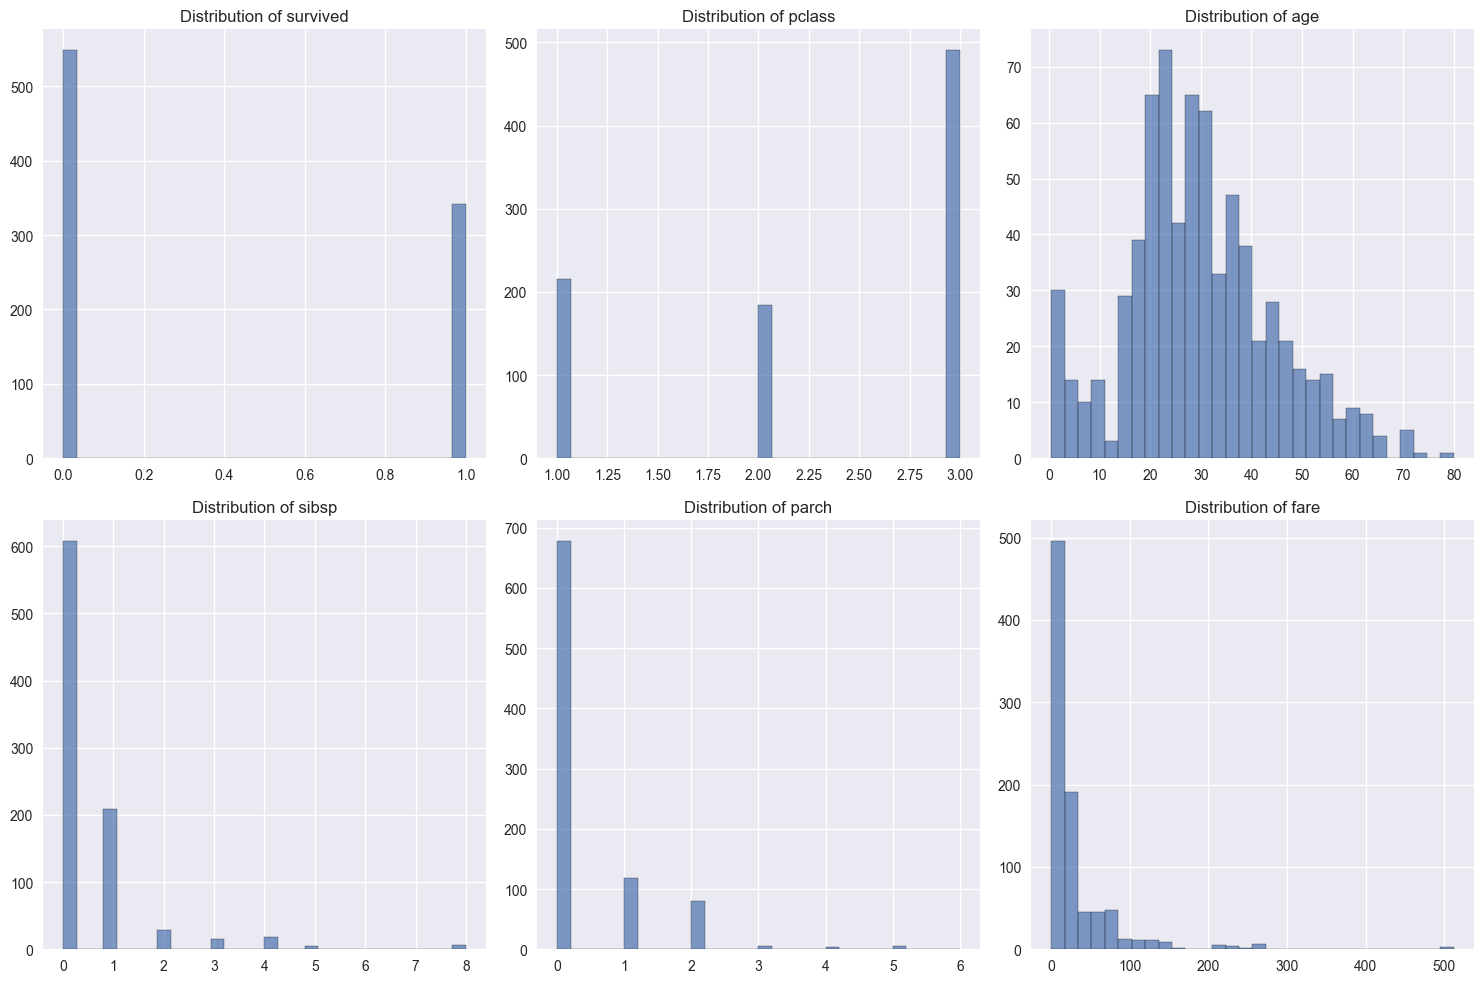

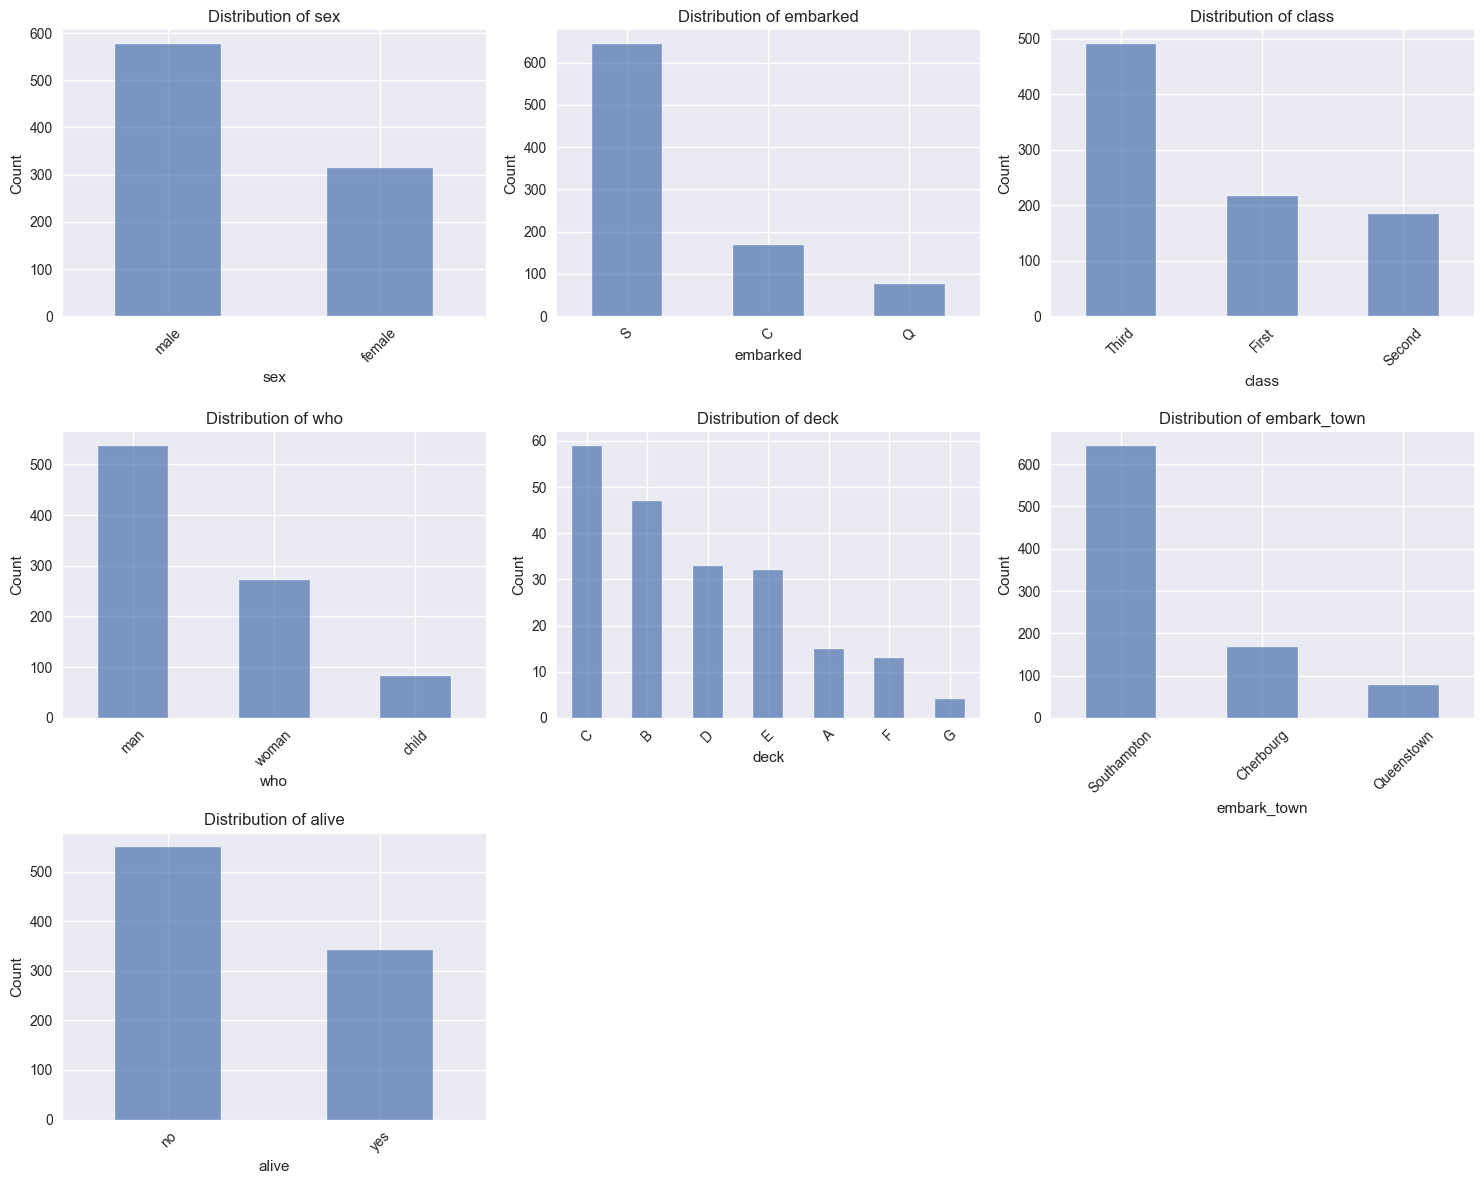

In [36]:
# Numerical distributions
numerical_cols = titanic.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(titanic[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Categorical distributions
categorical_cols = titanic.select_dtypes(include=['object', 'category']).columns
n_cols = 3
n_rows = math.ceil(len(categorical_cols) / n_cols)

plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    titanic[col].value_counts().plot(kind='bar', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


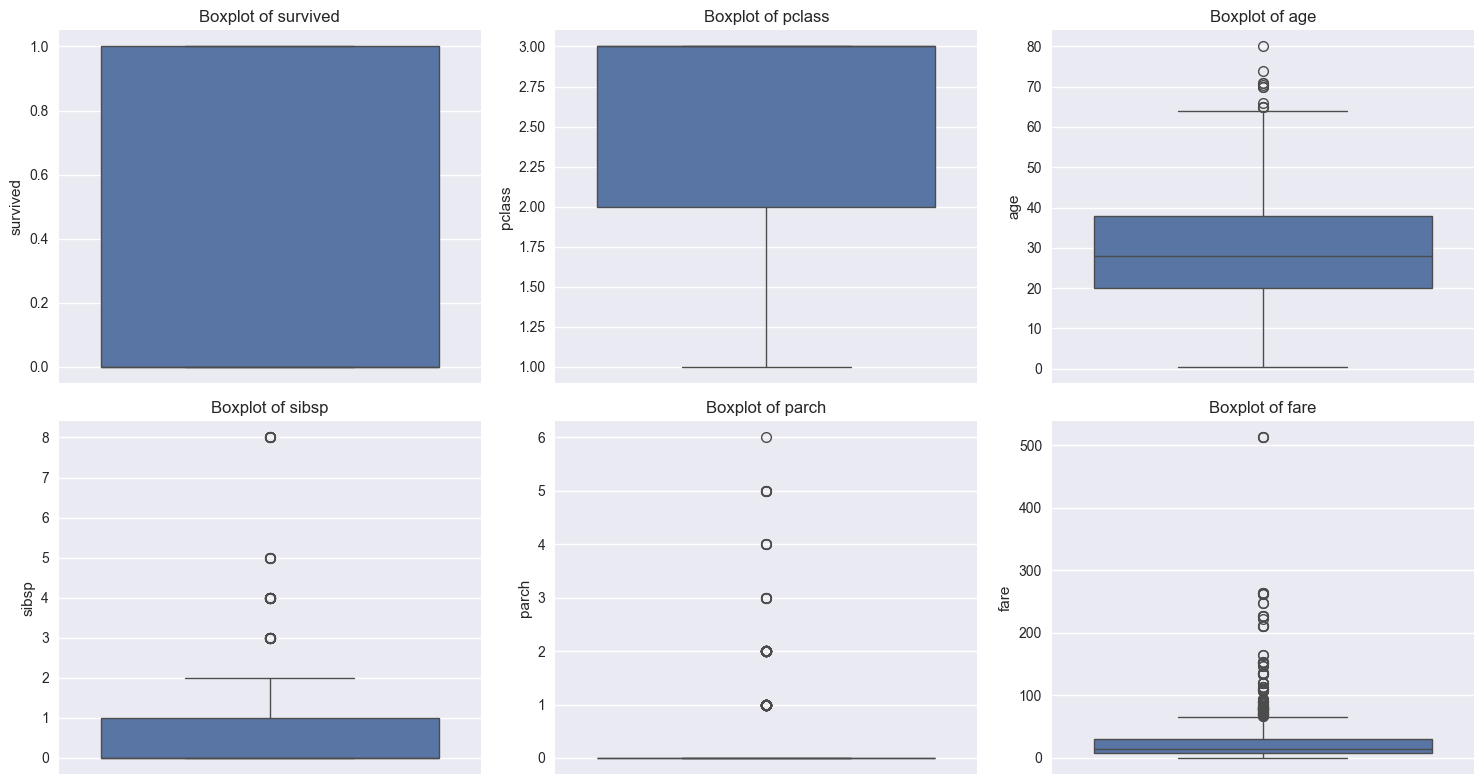

survived: 0 outliers
pclass: 0 outliers
age: 11 outliers
sibsp: 46 outliers
parch: 213 outliers
fare: 116 outliers


In [37]:
# Boxplots
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=titanic[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# IQR-based outlier detection
for col in numerical_cols:
    Q1 = titanic[col].quantile(0.25)
    Q3 = titanic[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = titanic[(titanic[col] < lower) | (titanic[col] > upper)]
    print(f"{col}: {len(outliers)} outliers")


Engineered Features: ['family_size', 'is_alone', 'age_group', 'fare_group']


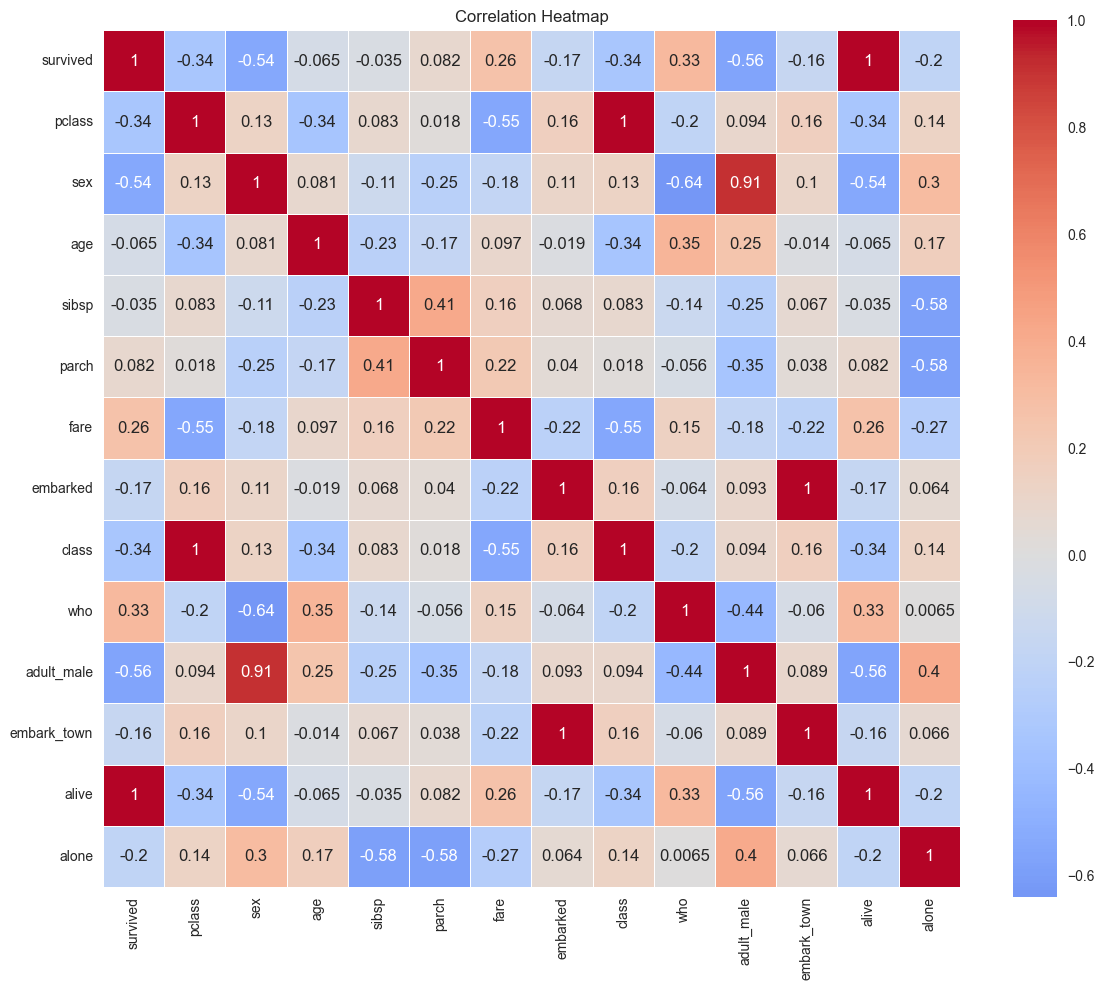

In [38]:
df = titanic.copy()
df['age'].fillna(df['age'].median(), inplace=True)
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)
df.drop('deck', axis=1, inplace=True)

df['family_size'] = df['sibsp'] + df['parch'] + 1
df['is_alone'] = (df['family_size'] == 1).astype(int)
df['age_group'] = pd.cut(df['age'], bins=[0, 12, 18, 35, 60, 100],
                         labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
df['fare_group'] = pd.cut(df['fare'], bins=4, labels=['Low', 'Medium', 'High', 'Very High'])
print("Engineered Features:", ['family_size', 'is_alone', 'age_group', 'fare_group'])


df_processed = titanic.copy()

# Handle missing values
df_processed['age'].fillna(df_processed['age'].median(), inplace=True)
df_processed['embarked'].fillna(df_processed['embarked'].mode()[0], inplace=True)
df_processed.drop('deck', axis=1, inplace=True)  # Too many missing values

# Encode categorical variables for correlation
le = LabelEncoder()
for col in ['sex', 'embarked', 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone']:
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))

# Correlation matrix
correlation_matrix = df_processed.corr()


# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [39]:
# Statistical tests for survival differences
print("Statistical Tests for Survival Differences:")

# Chi-square test for categorical variables
categorical_vars = ['sex', 'class', 'embarked', 'alone']
for var in categorical_vars:
    contingency_table = pd.crosstab(titanic[var], titanic['survived'])
    chi2_stat, p_value = stats.chi2_contingency(contingency_table)[:2]
    print(f"{var}: Chi-square = {chi2_stat:.3f}, p-value = {p_value:.3f}")

# T-test for numerical variables
numerical_vars = ['age', 'fare']
for var in numerical_vars:
    survived = titanic[titanic['survived'] == 1][var].dropna()
    not_survived = titanic[titanic['survived'] == 0][var].dropna()
    t_stat, p_value = stats.ttest_ind(survived, not_survived)
    print(f"{var}: T-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

# Survival rates by different combinations
print("\nSurvival Rates by Category Combinations:")
survival_combinations = titanic.groupby(['sex', 'class'])['survived'].agg(['count', 'mean'])
print(survival_combinations)

Statistical Tests for Survival Differences:
sex: Chi-square = 260.717, p-value = 0.000
class: Chi-square = 102.889, p-value = 0.000
embarked: Chi-square = 26.489, p-value = 0.000
alone: Chi-square = 36.001, p-value = 0.000
age: T-statistic = -2.067, p-value = 0.039
fare: T-statistic = 7.939, p-value = 0.000

Survival Rates by Category Combinations:
               count      mean
sex    class                  
female First      94  0.968085
       Second     76  0.921053
       Third     144  0.500000
male   First     122  0.368852
       Second    108  0.157407
       Third     347  0.135447


Top 10 features (Chi-square): ['pclass', 'age', 'fare', 'adult_male', 'is_alone', 'sex_male', 'class_Third', 'who_man', 'who_woman', 'alive_yes']


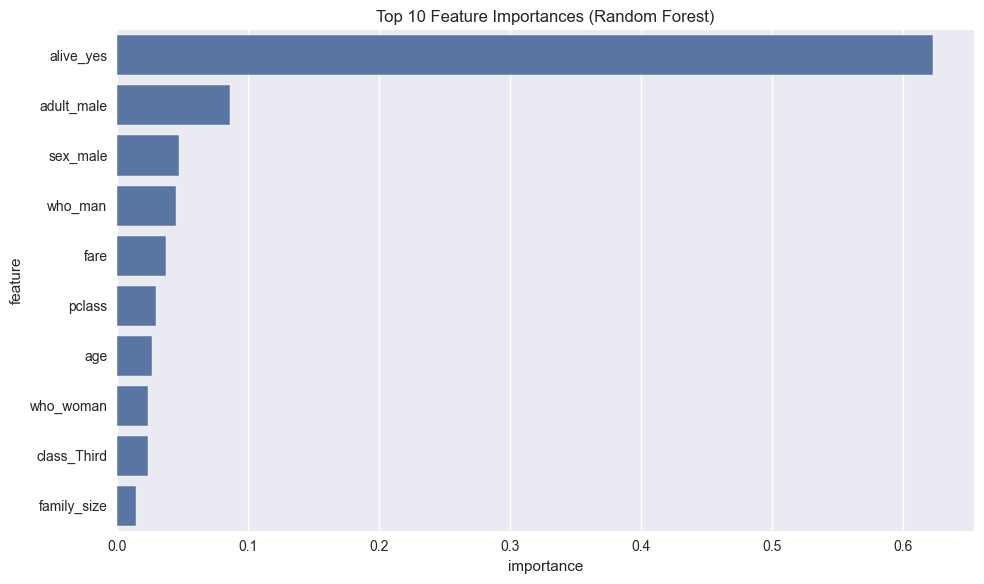

In [40]:
X = pd.get_dummies(df.drop('survived', axis=1), drop_first=True)
y = df['survived']

# SelectKBest (Chi-square)
selector = SelectKBest(score_func=chi2, k=10)
X_abs = np.abs(X)
X_kbest = selector.fit_transform(X_abs, y)
selected_features = X.columns[selector.get_support()]
print("Top 10 features (Chi-square):", list(selected_features))

# Feature Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
top_features = importances.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


PCA Explained Variance Ratio: [0.21423163 0.13377831]
LDA Explained Variance Ratio: [1.]
t-SNE completed


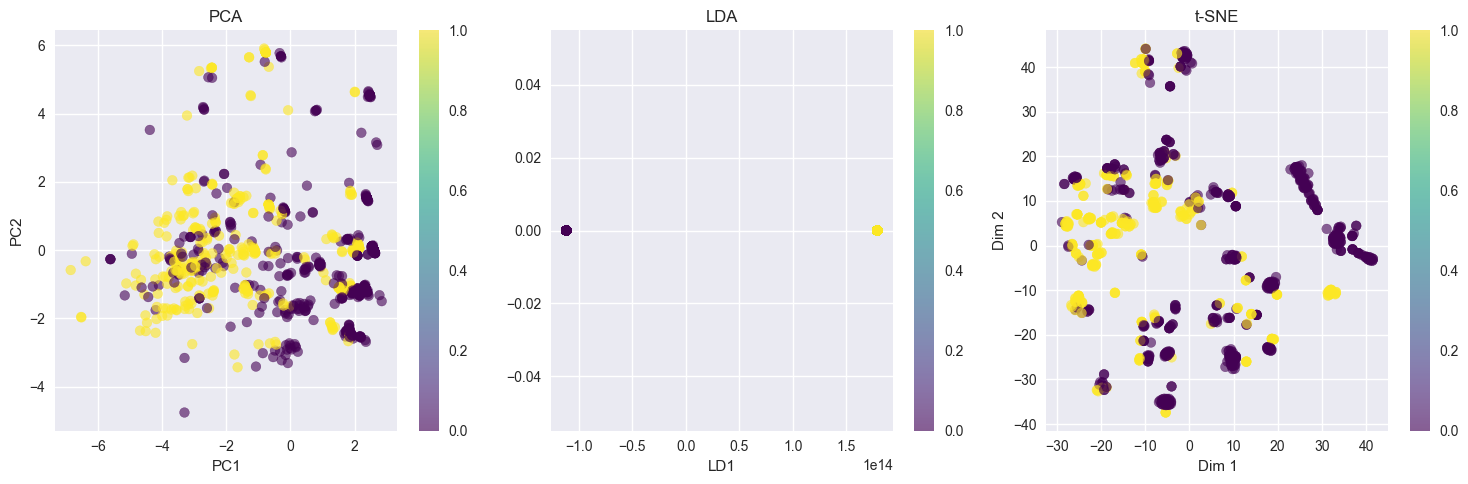

In [41]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("PCA Explained Variance Ratio:", pca.explained_variance_ratio_)

# LDA
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_scaled, y)
print("LDA Explained Variance Ratio:", lda.explained_variance_ratio_)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
print("t-SNE completed")


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title("PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(X_lda[:, 0], np.zeros_like(X_lda), c=y, cmap='viridis', alpha=0.6)
plt.title("LDA")
plt.xlabel("LD1")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title("t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar()

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Survival Rate: Age Group vs Class')

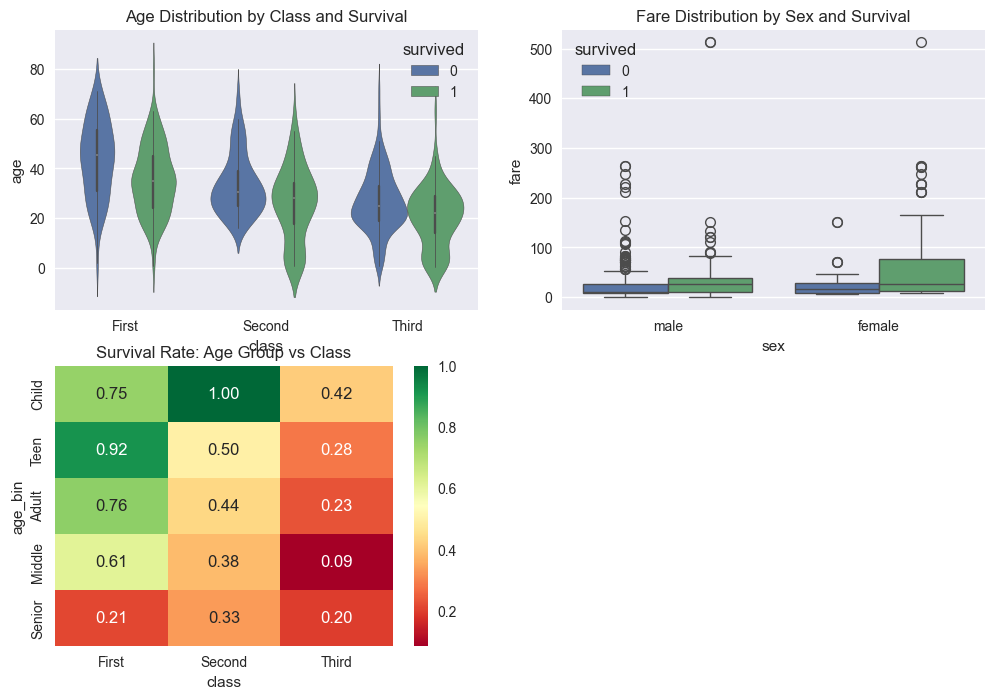

In [44]:
# Age and Class interaction
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.violinplot(data=titanic, x='class', y='age', hue='survived')
plt.title('Age Distribution by Class and Survival')

plt.subplot(2, 2, 2)
sns.boxplot(data=titanic, x='sex', y='fare', hue='survived')
plt.title('Fare Distribution by Sex and Survival')

plt.subplot(2, 2, 3)
# Create age bins for better visualization
titanic['age_bin'] = pd.cut(titanic['age'], bins=[0, 12, 18, 35, 60, 100], 
                           labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
survival_by_age_class = titanic.groupby(['age_bin', 'class'])['survived'].mean().unstack()
sns.heatmap(survival_by_age_class, annot=True, cmap='RdYlGn', fmt='.2f')
plt.title('Survival Rate: Age Group vs Class')




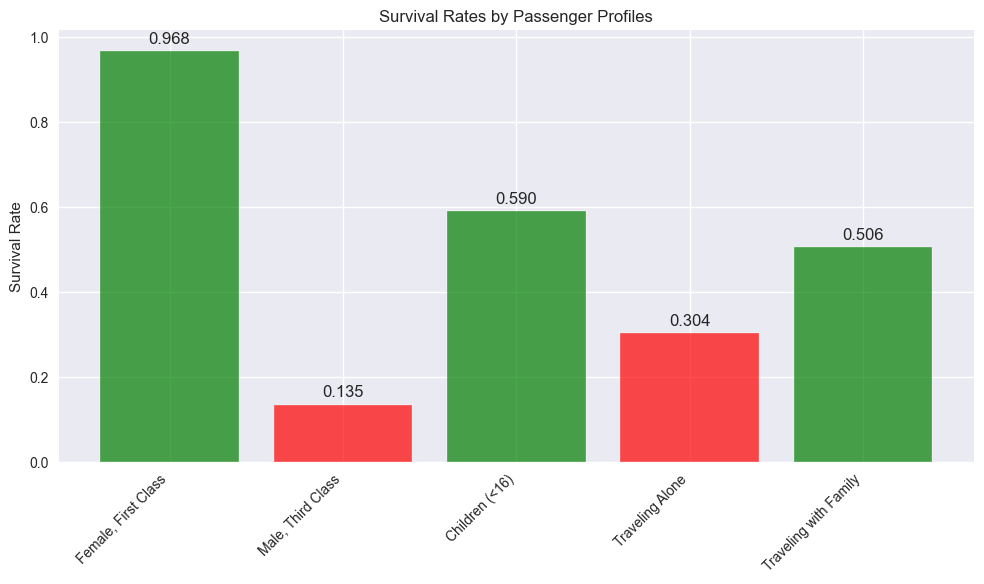

Passenger Profile Analysis:
Female, First Class: 0.968 survival rate
Male, Third Class: 0.135 survival rate
Children (<16): 0.590 survival rate
Traveling Alone: 0.304 survival rate
Traveling with Family: 0.506 survival rate


In [45]:
# Create passenger profiles
def create_passenger_profiles(df):
    profiles = []
    
    # High survival probability profile
    high_survival = df[(df['sex'] == 'female') & (df['class'] == 'First')]['survived'].mean()
    profiles.append(('Female, First Class', high_survival))
    
    # Low survival probability profile  
    low_survival = df[(df['sex'] == 'male') & (df['class'] == 'Third')]['survived'].mean()
    profiles.append(('Male, Third Class', low_survival))
    
    # Child profile
    child_survival = df[df['age'] < 16]['survived'].mean()
    profiles.append(('Children (<16)', child_survival))
    
    # Alone vs Family
    alone_survival = df[df['alone'] == True]['survived'].mean()
    family_survival = df[df['alone'] == False]['survived'].mean()
    profiles.append(('Traveling Alone', alone_survival))
    profiles.append(('Traveling with Family', family_survival))
    
    return profiles

profiles = create_passenger_profiles(titanic)

plt.figure(figsize=(10, 6))
profile_names = [p[0] for p in profiles]
survival_rates = [p[1] for p in profiles]

bars = plt.bar(profile_names, survival_rates, alpha=0.7, 
               color=['red' if rate < 0.5 else 'green' for rate in survival_rates])
plt.title('Survival Rates by Passenger Profiles')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, rate in zip(bars, survival_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{rate:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Passenger Profile Analysis:")
for profile, rate in profiles:
    print(f"{profile}: {rate:.3f} survival rate")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{name} Accuracy: {scores.mean():.3f} (+/- {scores.std()*2:.3f})")


Train shape: (712, 26), Test shape: (179, 26)
Logistic Regression Accuracy: 1.000 (+/- 0.000)
Random Forest Accuracy: 1.000 (+/- 0.000)


In [ ]:
# Logistic Regression - Grid Search
lr_grid = GridSearchCV(
    LogisticRegression(random_state=42), 
    {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
    cv=5, scoring='accuracy'
)
lr_grid.fit(X_train_scaled, y_train)
print("Best LR Params:", lr_grid.best_params_)

# Random Forest - Randomized Search
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    n_iter=10, cv=5, scoring='accuracy', random_state=42
)
rf_random.fit(X_train_scaled, y_train)
print("Best RF Params:", rf_random.best_params_)


Best LR Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best RF Params: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}



Logistic Regression
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Random Forest
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


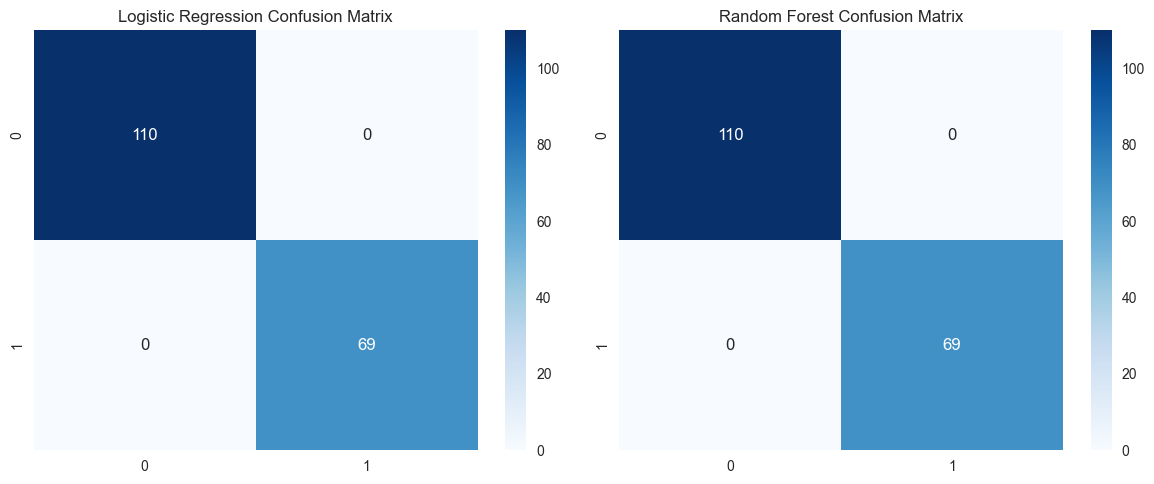

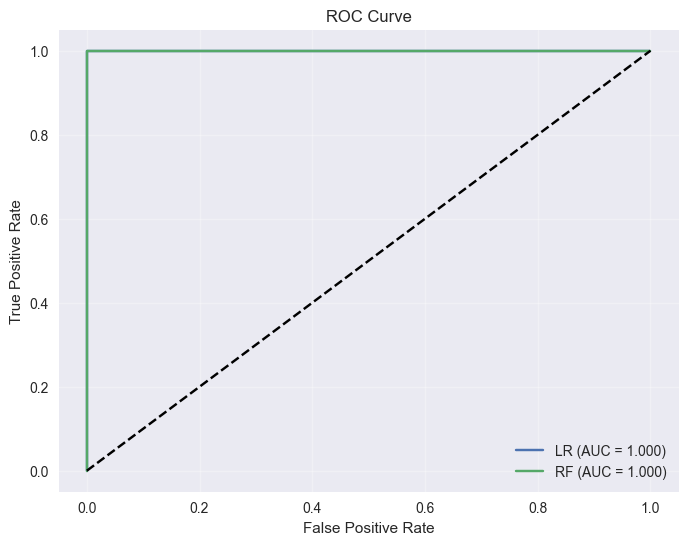

AUC - Logistic Regression: 1.000
AUC - Random Forest: 1.000


In [ ]:
best_lr = lr_grid.best_estimator_
best_rf = rf_random.best_estimator_

lr_pred = best_lr.predict(X_test_scaled)
rf_pred = best_rf.predict(X_test_scaled)

for name, pred in zip(['Logistic Regression', 'Random Forest'], [lr_pred, rf_pred]):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("Precision:", precision_score(y_test, pred))
    print("Recall:", recall_score(y_test, pred))
    print("F1 Score:", f1_score(y_test, pred))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")

plt.tight_layout()
plt.show()

lr_probs = best_lr.predict_proba(X_test_scaled)[:, 1]
rf_probs = best_rf.predict_proba(X_test_scaled)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)

auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC = {auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC - Logistic Regression: {auc_lr:.3f}")
print(f"AUC - Random Forest: {auc_rf:.3f}")



Regression Metrics:
MSE: 303.9101529455319
RMSE: 17.433019042768578
R²: 0.8036032468751404


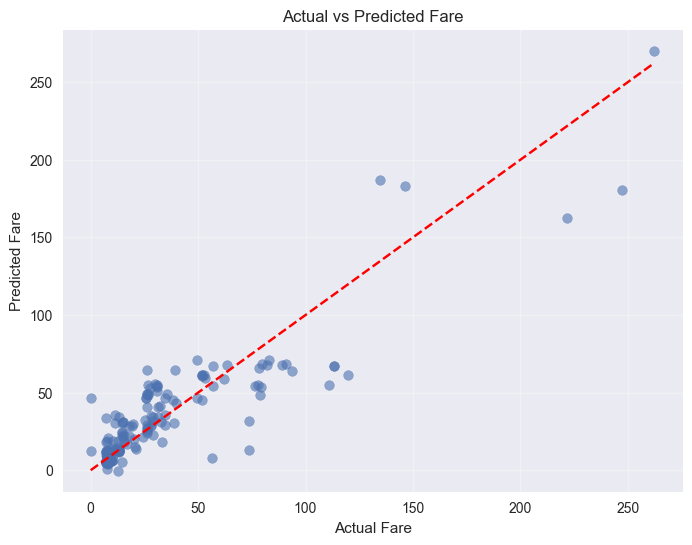

In [ ]:
# Use 'fare' as target for regression
X_reg = df.drop(['fare'], axis=1)
y_reg = df['fare']
X_reg = pd.get_dummies(X_reg, drop_first=True)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_reg_train_scaled = scaler.fit_transform(X_reg_train)
X_reg_test_scaled = scaler.transform(X_reg_test)

reg_model = LinearRegression()
reg_model.fit(X_reg_train_scaled, y_reg_train)
y_reg_pred = reg_model.predict(X_reg_test_scaled)

mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_reg_test, y_reg_pred)

print("Regression Metrics:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.6)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs Predicted Fare")
plt.grid(True, alpha=0.3)
plt.show()

